In [1]:
import numpy as np
import matplotlib.pylab as plt
import networkx as nx
from pathlib import Path
import sqlite3
import sknw
from skimage.morphology import skeletonize

## Recreate Graph from Database

In [2]:
# path to databank where you want to recreate graph from
#db_path = Path('E:/DB Browser for SQLite/Datenbanken/HumanA/test.db')
# path to databases
print("For which experiment would you like to recreate the graph?")
experiment = int(input())
if experiment == 1:
    db_path = Path('E:/HumanA/Data/DataBase/HumanA_Exp1.db')
    #db_path = Path('E:/HumanA/Data/HumanA_Exp1_WorkingData.db')
elif experiment == 2:
    db_path = Path('E:/HumanA/Data/DataBase/HumanA_Exp2.db')
    #db_path = Path('E:/HumanA/Data/HumanA_Exp2_WorkingData.db')

if not db_path or not db_path.exists():
    db_path = ':memory:'

For which experiment would you like to recreate the graph?
2


In [3]:
# connect to database
connection=sqlite3.connect(db_path)
cr=connection.cursor()

In [4]:
sql_instruction = """ SELECT Nodes, Radius FROM nodes_radius"""
cr.execute(sql_instruction)

In [5]:
nodes_data = cr.fetchall()

In [6]:
nodes = list(list(zip(*nodes_data))[0])
r = list(list(zip(*nodes_data))[1])
radius_list = dict(zip(*(nodes,r)))

In [7]:
# get mask from database
sql_instruction = """ SELECT Row, Column,Value FROM mask_information"""
cr.execute(sql_instruction)

In [8]:
mask_values = cr.fetchall()

In [9]:
# recreate mask from database
last_row = 0
mask_values_current_row = []
mask_values_complete = []
for i in mask_values:
    if i[0] == last_row:
        mask_values_current_row.append(i[2])
    else:
        mask_values_complete.append(mask_values_current_row)
        mask_values_current_row = [i[2]]
    last_row = i[0]
    
mask = np.asarray(mask_values_complete)

In [10]:
def rotate_matrix(matrix):
    return np.rot90(np.flip(matrix, axis=0), k=-1)

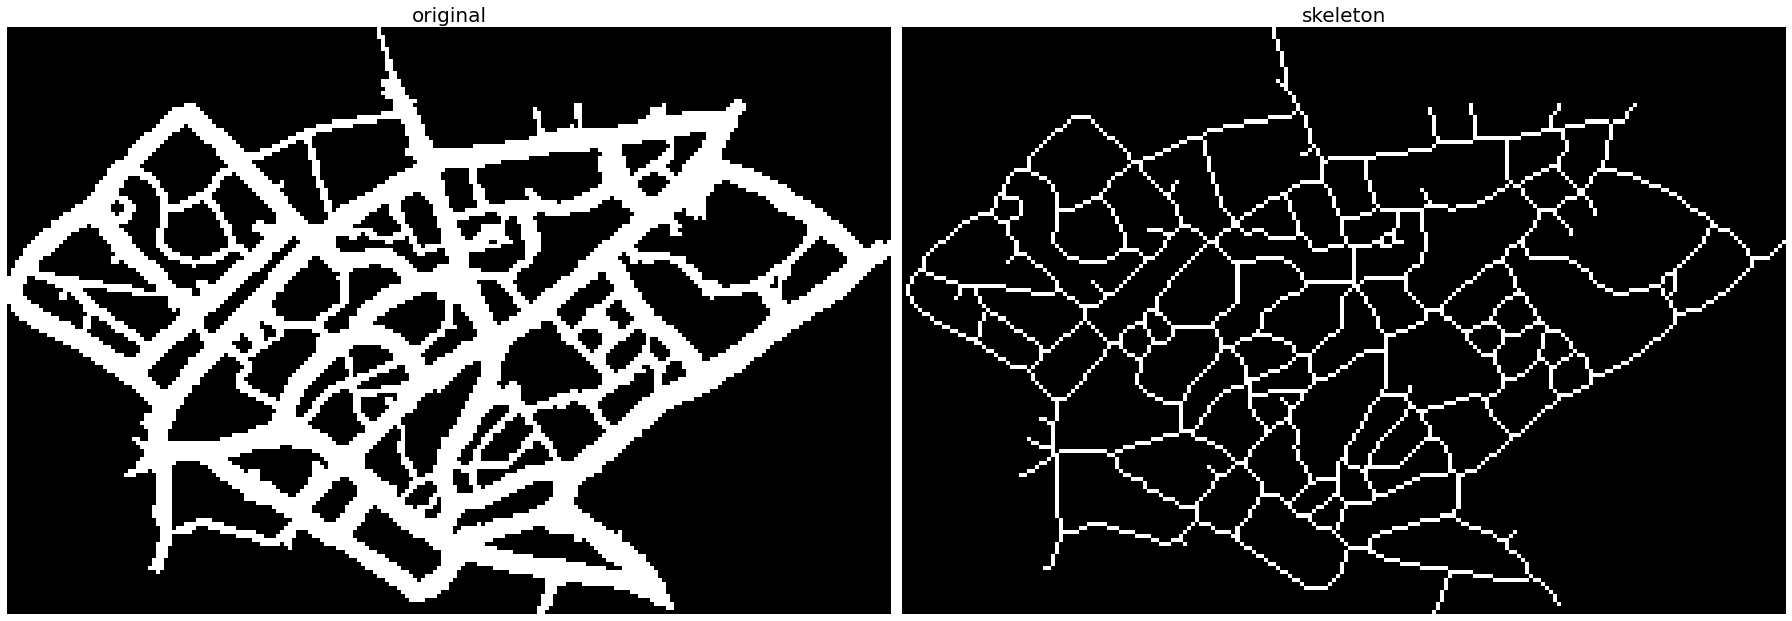

In [11]:
skeleton = skeletonize(mask)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 20),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(rotate_matrix(mask), cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(rotate_matrix(skeleton), cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.gca().invert_yaxis()
plt.show()

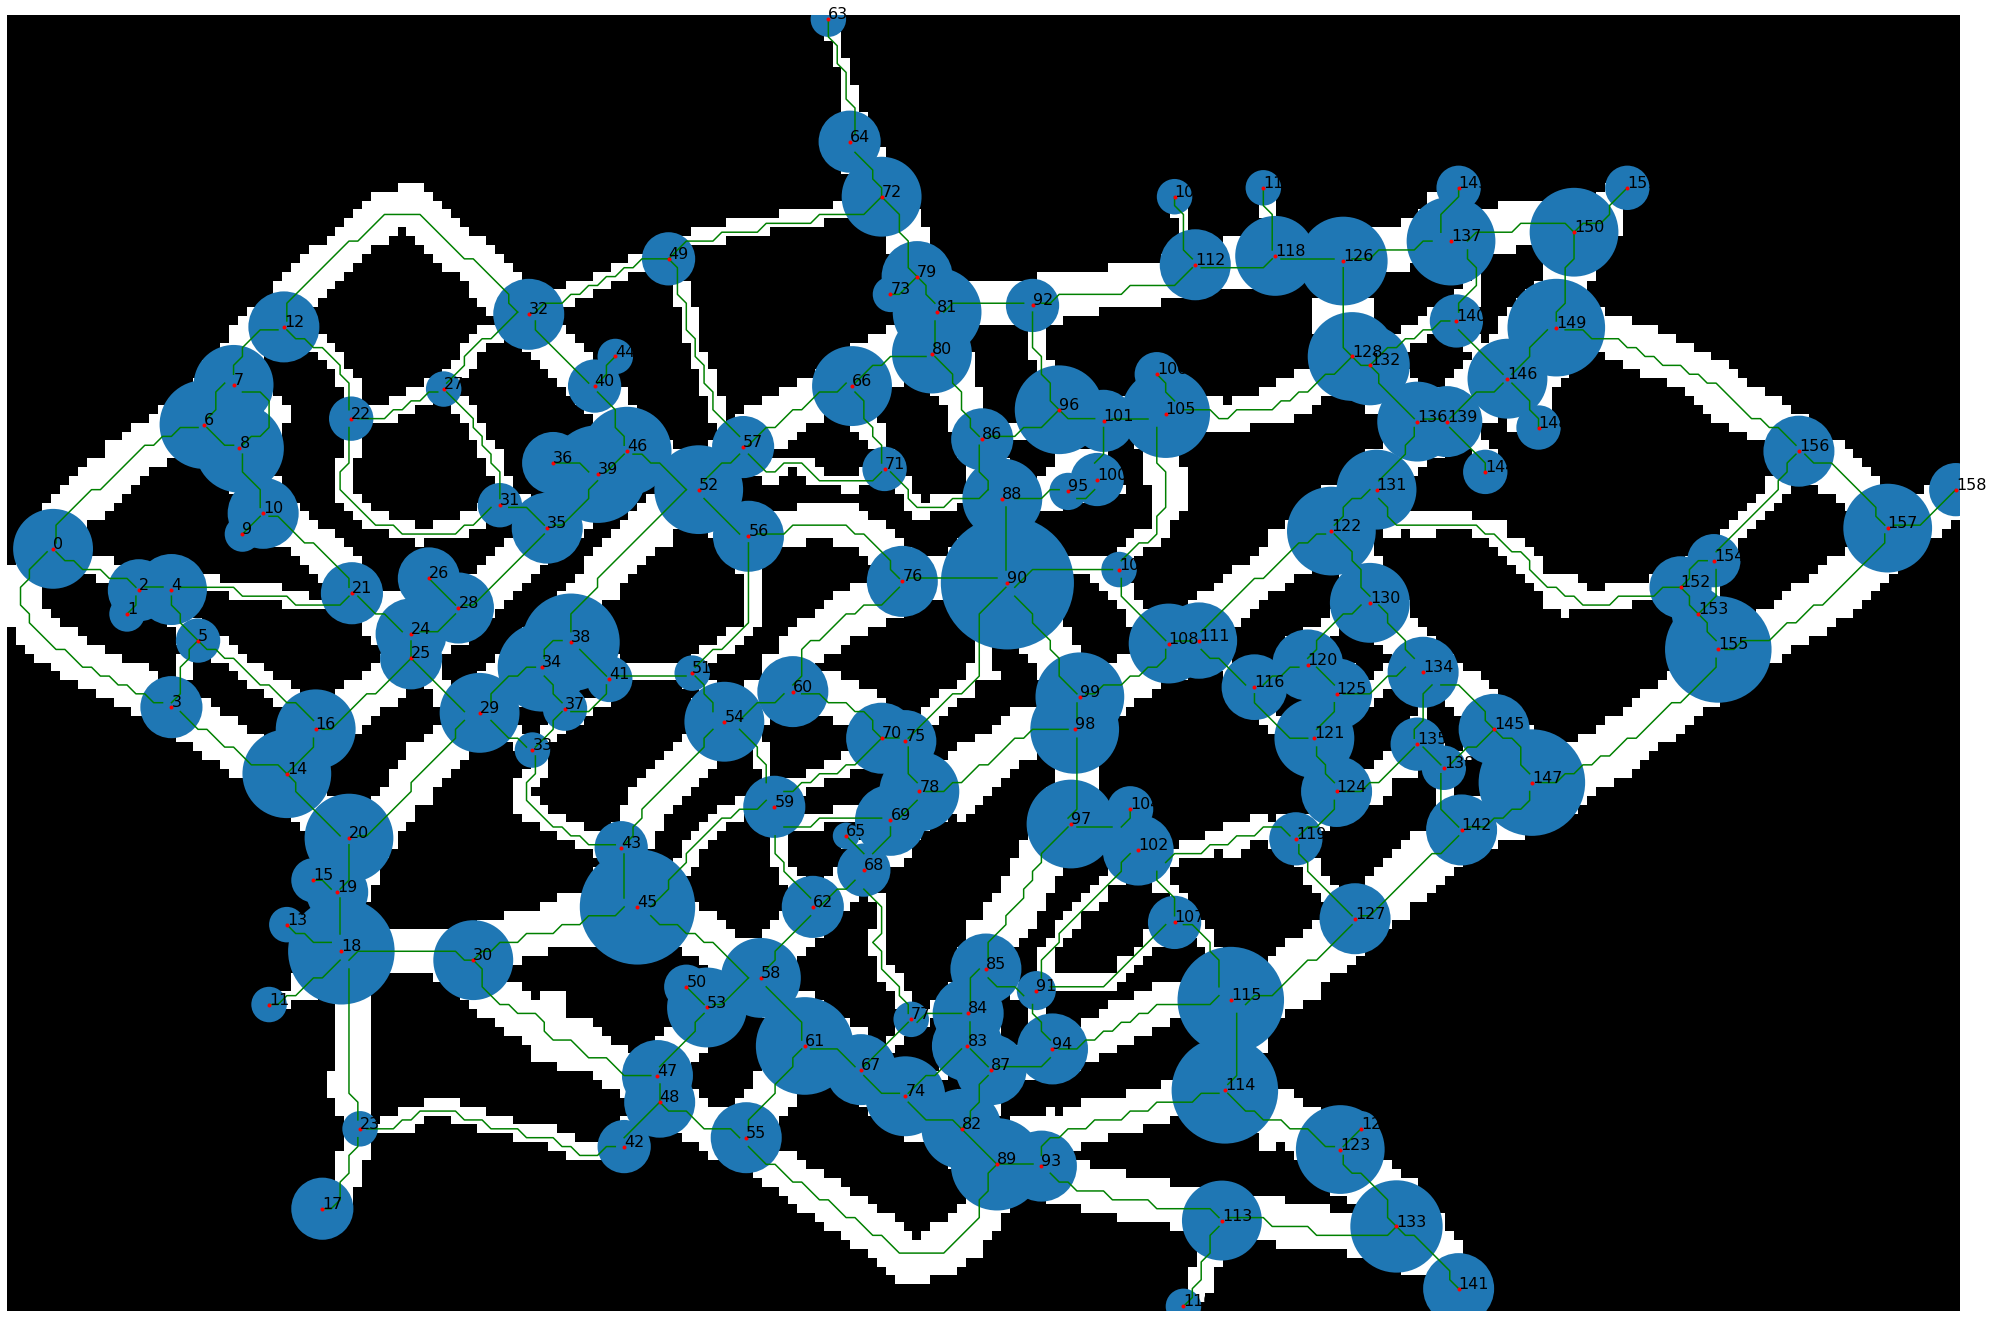

In [12]:
empty_graph = sknw.build_sknw(skeleton)
nx.set_node_attributes(empty_graph, radius_list, "r")

plt.figure(figsize=(35,50))
plt.imshow(rotate_matrix(mask), cmap='gray')
plt.axis('off')

# draw edges by pts
for (s,e) in empty_graph.edges():
    ps = empty_graph[s][e]['pts']
    plt.plot(ps[:,0], ps[:,1], 'green')
    
# draw node by o
nodes = empty_graph.nodes()
for node in nodes:
    #print(nodes[node])
    radius = nodes[node]['r']
    ps = nodes[node]['o']
    plt.text(ps[0] , ps[1], node, fontsize=16)
    c = plt.Circle(( ps[0] , ps[1] ), radius )
    plt.gca().add_artist(c)
    plt.plot(ps[0], ps[1], 'r.')

# title and show
plt.gca().invert_yaxis()
plt.show()


In [13]:
connection.close()